# Laboratorio 6: Algoritmos Genéticos para Resolución de Problemas Complejos

#### Ignacio Chaparro - 202220577
#### Mateo Lopez - 

## Problema 1: Corridor Crawler (Laberinto Determinístico)

En este problema, los estudiantes asumen el rol de ingenieros de robótica contratados para automatizar una instalación postal subterránea. La tarea inmediata consiste en desarrollar un robot de tipo micromouse que pueda salir de un laberinto fijo de 20 × 20 lo más rápido posible. El objetivo es evolucionar una estrategia de navegación (conjunto de reglas o secuencia de movimientos) que permita al robot encontrar la salida del laberinto de manera eficiente, minimizando el número de pasos y evitando colisiones con parede


Inicialmente, procederemos con la carga de un caso a resolver el caso base.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

In [2]:
def display_maze(maze):
    cmap = ListedColormap(['white', 'black', 'green', 'black'])
    plt.figure(figsize=(6, 6))
    plt.pcolor(maze[::-1], cmap=cmap, edgecolors='k', linewidths=2)
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.title('Maze with Entrance and Exit')
    plt.show()
    
def load_maze(file):
    maze = np.loadtxt(file, dtype=int)
    return maze

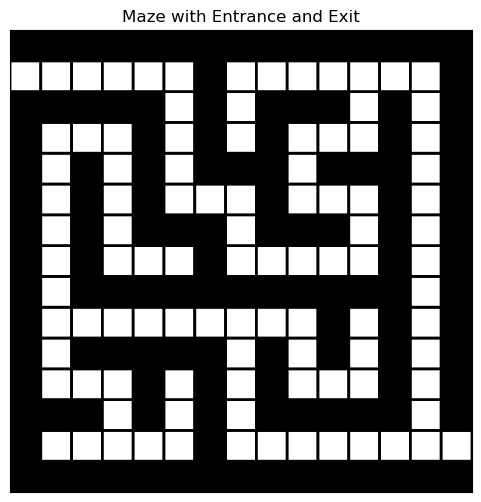

Dimensiones del Laberinto:  (15, 15)


In [9]:
maze = load_maze('maze_case_base.txt')
# maze = load_maze('maze_case_heavy.txt')
display_maze(maze)
print("Dimensiones del Laberinto: ", maze.shape)

Ya con el laberinto cargado, procederemos con la implementación del algoritmo genético para la resolución del problema

Primero deberemos definir la manera en que vamos a representar los cromosomas. En nuestro caso, cada gen va a ser un entero de 0 - 3 

| Numero | Movimiento |
|--------|------------|
| 0 | UP |
| 1 | DOWN |
| 2 | LEFT |
| 3 | RIGHT |

 que va representar la serie de pasos que va a tomar el individuo para navegar por el laberinto. Estos cromosomas van a tener una longitud maxima, correspondiente a las dimensiones del tablero $L * W$.

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# ─────────────────────────────────────────────────────
# 1) Carga y perímetro
# ─────────────────────────────────────────────────────
def load_maze(path):
    """Carga un laberinto desde un .txt con 0=pasillo, 1=muro."""
    return np.loadtxt(path, dtype=int)

# ─────────────────────────────────────────────────────
# 2) Representación y operadores genéticos
# ─────────────────────────────────────────────────────
MOVES = {
    0: (-1,  0),  # UP
    1: (+1,  0),  # DOWN
    2: ( 0, -1),  # LEFT
    3: ( 0, +1),  # RIGHT
}

def crear_individuo(L_max, start, goal, slack=1.2):
    """Genera ruta aleatoria de longitud entre Manhattan*slack y L_max."""
    manh = abs(start[0]-goal[0]) + abs(start[1]-goal[1])
    min_len = max(1, int(manh * slack))
    length = random.randint(min_len, L_max)
    return [random.randint(0, 3) for _ in range(length)]

def crossover_one_point(p1, p2, L_max):
    """One-point crossover seguro para cromosomas variables."""
    if len(p1) < 2 or len(p2) < 2:
        return p1[:L_max].copy(), p2[:L_max].copy()
    i = random.randint(1, len(p1)-1)
    j = random.randint(1, len(p2)-1)
    h1 = (p1[:i] + p2[j:])[:L_max]
    h2 = (p2[:j] + p1[i:])[:L_max]
    return h1, h2

def mutar(ind, L_max, p_sub=0.1, p_ins=0.05, p_del=0.05):
    """Sustitución, inserción y borrado con chequeos de rango."""
    # Sustitución
    if len(ind) > 0 and random.random() < p_sub:
        ind[random.randrange(len(ind))] = random.randint(0,3)
    # Inserción
    if len(ind) < L_max and random.random() < p_ins:
        idx = random.randrange(len(ind)+1)
        ind.insert(idx, random.randint(0,3))
    # Borrado
    if len(ind) > 1 and random.random() < p_del:
        ind.pop(random.randrange(len(ind)))
    return ind

# ─────────────────────────────────────────────────────
# 3) Simulación y fitness
# ─────────────────────────────────────────────────────
def is_valid(pos, maze):
    r, c = pos
    R, C = maze.shape
    return 0 <= r < R and 0 <= c < C and maze[r, c] == 0

def simulate(ind, maze, start, goal):
    """Ejecuta la ruta; devuelve pasos, colisiones, reached, final_pos."""
    pos = start
    pasos = col = 0
    for g in ind:
        dr, dc = MOVES[g]
        nxt = (pos[0]+dr, pos[1]+dc)
        if is_valid(nxt, maze):
            pos = nxt
        else:
            col += 1
        pasos += 1
        if pos == goal:
            return pasos, col, True, goal
    return pasos, col, False, pos

def fitness(ind, maze, start, goal,
            col=10, dist=1, exit=1e6):
    """
    - Si llega: fitness = pasos + col·colisiones
    - Si no llega: fitness = exit + dist·Manhattan(final,goal)
    """
    pasos, col, reached, final = simulate(ind, maze, start, goal)
    if reached:
        return pasos + col * col
    manh = abs(final[0]-goal[0]) + abs(final[1]-goal[1])
    return exit + dist * manh

# ─────────────────────────────────────────────────────
# 4) Selección
# ─────────────────────────────────────────────────────
def tournament_selection(pop, fits, k=3):
    aspir = random.sample(list(zip(pop, fits)), k)
    return min(aspir, key=lambda x: x[1])[0]

# ─────────────────────────────────────────────────────
# 5) Bucle GA
# ─────────────────────────────────────────────────────
def run_ga(maze, start, goal,
           pop_size, n_gen,
           cxpb, mutpb):
    R, C = maze.shape
    L_max = R * C

    # 1) Inicializa población
    pop = [crear_individuo(L_max, start, goal) for _ in range(pop_size)]
    fits = [fitness(ind, maze, start, goal) for ind in pop]

    # 2) Guarda el mejor hasta ahora
    best_idx = int(np.argmin(fits))
    best_ind = pop[best_idx].copy()
    best_fit = fits[best_idx]

    # 3) Evolución
    history = [best_fit]
    for gen in range(1, n_gen+1):
        new_pop = [best_ind.copy()]  # elitismo

        while len(new_pop) < pop_size:
            p1 = tournament_selection(pop, fits)
            p2 = tournament_selection(pop, fits)
            if random.random() < cxpb:
                c1, c2 = crossover_one_point(p1, p2, L_max)
            else:
                c1, c2 = p1.copy(), p2.copy()
            if random.random() < mutpb:
                c1 = mutar(c1, L_max)
            if random.random() < mutpb:
                c2 = mutar(c2, L_max)

            new_pop.append(c1)
            if len(new_pop) < pop_size:
                new_pop.append(c2)

        pop = new_pop
        fits = [fitness(ind, maze, start, goal) for ind in pop]

        idx = int(np.argmin(fits))
        if fits[idx] < best_fit:
            best_fit = fits[idx]
            best_ind = pop[idx].copy()

        history.append(best_fit)

        pasos, col, reached, _ = simulate(best_ind, maze, start, goal)
        if reached:
            print(f"Solved in gen={gen}, pasos={pasos}, colisiones={col}")
            break

    return best_ind, best_fit, history

# ─────────────────────────────────────────────────────
# 6) Visualización
# ─────────────────────────────────────────────────────
def display_solution(maze, route, start, goal):
    R, C = maze.shape

    # Dibuja base blanco/negro
    cmap = ListedColormap(['white','black'])
    plt.figure(figsize=(6,6))
    plt.pcolor(maze[::-1], cmap=cmap, edgecolors='k', linewidths=1)
    plt.gca().set_aspect('equal')
    plt.xticks([]); plt.yticks([])

    # Reconstruye camino
    pos = start
    path = [pos]
    for g in route:
        dr, dc = MOVES[g]
        nxt = (pos[0]+dr, pos[1]+dc)
        if is_valid(nxt, maze):
            pos = nxt
        path.append(pos)
        if pos == goal:
            break

    xs = [c+0.5 for r,c in path]
    ys = [(R-1-r)+0.5 for r,c in path]
    plt.plot(xs, ys, '-r', linewidth=2, marker='o', markersize=4)
    plt.scatter([xs[0], xs[-1]], [ys[0], ys[-1]],
                c='green', s=100, zorder=3)

    plt.title('Maze + Solution Path')
    plt.show()



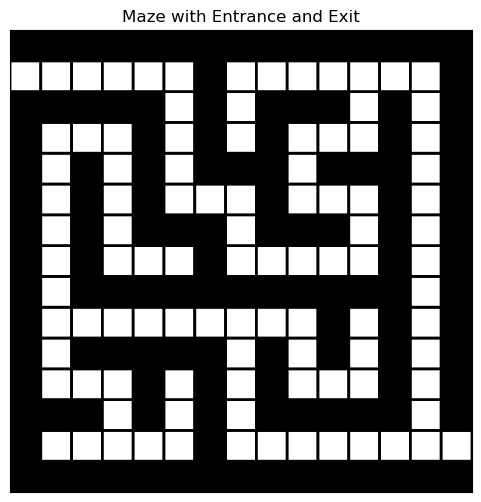

Solved in gen=14, pasos=217, colisiones=105
Mejor fitness: 1267


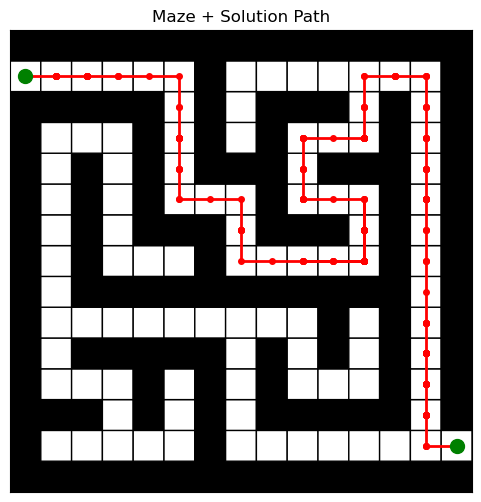

In [49]:
maze = load_maze("maze_case_base.txt")
display_maze(maze)
R, C = maze.shape
start = (1, 0)
goal  = (R-2, C-1)

POP_SIZE=300
N_GEN=200
CXPB=0.7
MUTPB=0.2

best_route, best_fit, hist = run_ga(maze, start, goal, POP_SIZE, N_GEN, CXPB, MUTPB)

print("Mejor fitness:", best_fit)
display_solution(maze, best_route, start, goal)

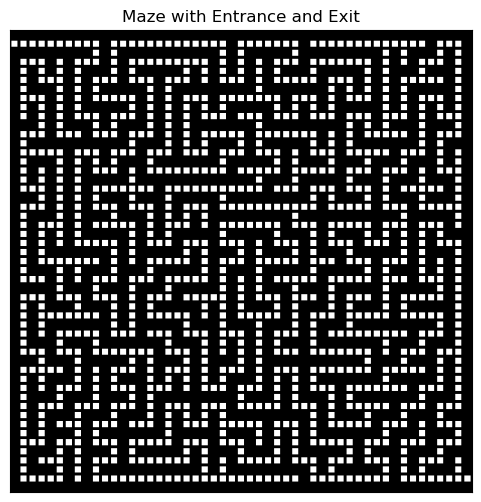

Mejor fitness: 1000053.0


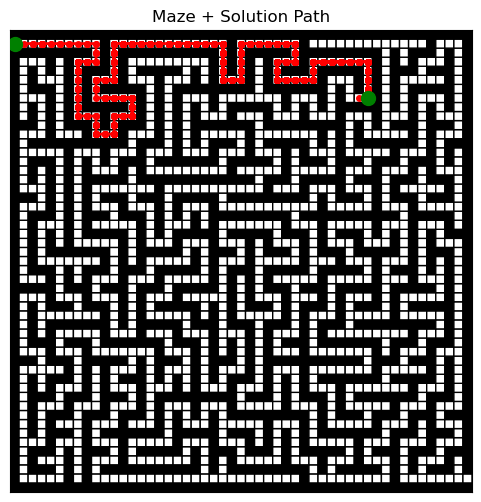

In [52]:
maze = load_maze("maze_case_heavy.txt")
display_maze(maze)
R, C = maze.shape
start = (1, 0)
goal  = (R-2, C-1)

POP_SIZE=500
N_GEN=200
CXPB=0.7
MUTPB=0.2

best_route, best_fit, hist = run_ga(maze, start, goal, POP_SIZE, N_GEN, CXPB, MUTPB)

print("Mejor fitness:", best_fit)
display_solution(maze, best_route, start, goal)

Despues de correr varias pruebas, podemos ver que nuestro algoritmo genético logra encontrar rapidamente la solución para el caso base, en aproximadamente 12 generaciones.